Sinhala News Classification using LSTM with FastText Embeddings
📘 Module Overview

This notebook develops a Deep Learning model to classify Sinhala news headlines into three categories — International, Business, and Sport — using an LSTM neural network combined with FastText Sinhala word embeddings.

The model learns the relationships between Sinhala words and their categories, enabling it to predict which label a new unseen news headline belongs to.
This approach creates a strong neural baseline model, more advanced than TF-IDF but lighter than transformer-based architectures.

1. Import Required Libraries

Description:
.Before we begin, we must import all the necessary Python modules. Each library plays a key role:

.pandas / numpy → handle and manipulate data.

.matplotlib / seaborn → visualize data and results.

.tensorflow.keras → build and train the LSTM deep learning model.

.sklearn → handle label encoding, data splitting, and evaluation metrics.

These modules provide every essential tool for text preprocessing, model creation, and evaluation.

In [1]:
# Import essential libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import TensorFlow and Keras for deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Import sklearn tools for preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


2. Load and Explore the Dataset

Description:
Now we will load our Sinhala News Dataset, which contains two columns:

Title – the Sinhala news headline (text).

Label – the category of the headline (International / Business / Sport).

We will inspect its structure, look for missing data, and count how many samples each category contains.
👉 Replace the file path with your own file location if you uploaded it to Google Drive.

In [2]:
# ⚠️ Update the file path below if your dataset is in Google Drive
df = pd.read_csv('/content/Sinhala_news_articles.csv')

# Display shape and first few rows
print("Dataset shape:", df.shape)
print(df.head())

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# View distribution of categories
print("\nLabel distribution:\n", df['Label'].value_counts())


Dataset shape: (26420, 2)
                                               Title          Label
0               කොරෝනා වැලඳුණු ට්‍රම්ප් අද ජන රැලියක  International
1  ආර්ථික විද්‍යාව පිළිබඳ නොබෙල් ත්‍යාගය ඇමරිකානු...  International
2        ඉන්දියාවේ කොරෝනා ආසාදිතයන් 71 ලක්ෂය ඉක්මවයි  International
3  කළු ජාතිකයෙකු ඩොලර් මිලියනයක වන්දි ඉල්ලා ටෙක්ස...  International
4                          නේපාල සංචාරක ඇමතිට කොරෝනා  International

Missing values:
 Title    0
Label    0
dtype: int64

Label distribution:
 Label
International    12009
Sport             9088
Business          5323
Name: count, dtype: int64


3. Data Cleaning (Preprocessing Text)

Description:
Before feeding the data into our model, we must clean the Sinhala text.
This involves removing:

Numbers

English or punctuation characters

Extra white spaces

This ensures only meaningful Sinhala characters remain for training.

In [3]:
import re

def clean_text(text):
    text = re.sub(r'[0-9]', '', text)                    # Remove numbers
    text = re.sub(r'[^\u0D80-\u0DFF\s]', '', text)       # Keep only Sinhala letters
    text = text.strip()
    return text

# Apply cleaning to all titles
df['Title'] = df['Title'].astype(str).apply(clean_text)

# Display few cleaned titles
df.head()


,Title,Label
0,කොරෝනා වැලඳුණු ට්රම්ප් අද ජන රැලියක,International
1,ආර්ථික විද්යාව පිළිබඳ නොබෙල් ත්යාගය ඇමරිකානුවන...,International
2,ඉන්දියාවේ කොරෝනා ආසාදිතයන් ලක්ෂය ඉක්මවයි,International
3,කළු ජාතිකයෙකු ඩොලර් මිලියනයක වන්දි ඉල්ලා ටෙක්ස...,International
4,නේපාල සංචාරක ඇමතිට කොරෝනා,International


4. Tokenization and Padding

Description:
Machines cannot understand words directly; they need numbers.
We tokenize the Sinhala text (each unique word gets a number ID) and then pad all sentences to equal length.
This allows the LSTM model to read every input sequence in the same size.

In [4]:
MAX_WORDS = 10000  # maximum number of unique words to keep
MAX_LEN = 20       # fixed length of each sequence

# Convert text to integer sequences
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['Title'])
X = tokenizer.texts_to_sequences(df['Title'])

# Pad all sequences to the same length
X = pad_sequences(X, maxlen=MAX_LEN, padding='post')

print("Vocabulary size:", len(tokenizer.word_index))
print("Example sequence:", X[0])


Vocabulary size: 20735
Example sequence: [  72   42    8 1818    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


5. Encode Category Labels

Description:
The Label column contains text categories like “International.”
We must convert them into numeric format because the model expects numbers.
Finally, we transform them into one-hot vectors for multi-class classification.

In [5]:
# Encode text labels to integers
le = LabelEncoder()
y = le.fit_transform(df['Label'])

# Convert to one-hot encoded form
y = to_categorical(y)

print("Label classes:", le.classes_)


Label classes: ['Business' 'International' 'Sport']


6. Download and Load FastText Sinhala Embeddings

Description:
FastText is a pre-trained embedding model developed by Facebook that already knows the meaning of Sinhala words.
We’ll download cc.si.300.vec, which contains 300-dimensional vectors for thousands of Sinhala words.
Using these embeddings helps the LSTM understand word meanings without starting from scratch.

In [6]:
# Download FastText Sinhala word embeddings
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.vec.gz
!gunzip cc.si.300.vec.gz

# Load embeddings into a dictionary
embedding_index = {}
with open('cc.si.300.vec', encoding='utf-8', errors='ignore') as f:
    next(f)  # skip header
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print("Loaded %s word vectors." % len(embedding_index))


--2025-10-12 10:54:07--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 54.240.184.75, 54.240.184.91, 54.240.184.45, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|54.240.184.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481477801 (459M) [binary/octet-stream]
Saving to: ‘cc.si.300.vec.gz’

cc.si.300.vec.gz    100%[===================>] 459.17M   168MB/s    in 2.7s    

2025-10-12 10:54:10 (168 MB/s) - ‘cc.si.300.vec.gz’ saved [481477801/481477801]

Loaded 808044 word vectors.


7. Create the Embedding Matrix

Description:
Now we align the FastText word vectors with our dataset vocabulary.
For every Sinhala word in our dataset, we check if it exists in FastText and copy its pre-trained vector.
If a word is missing, it stays as a zero vector.

In [7]:
embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


8. Build the LSTM Model

Description:
Here we create our LSTM neural network architecture.

The Embedding layer uses the FastText Sinhala vectors (not trainable).

The LSTM layer captures the sequence pattern of Sinhala words.

The Dense layers perform the final classification into the three categories.

This model will learn both word meaning and sentence structure.

In [8]:
model = Sequential([
    Embedding(input_dim=len(word_index) + 1,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=MAX_LEN,
              trainable=False),  # keep FastText weights fixed
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')  # 3 output classes
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,220,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,220,800 (23.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,220,800 (23.73 MB)

9. Train the Model

Description:
We split the dataset into training (80%) and testing (20%) sets.
Then, we train the LSTM model using categorical cross-entropy loss and Adam optimizer.
Training teaches the model how to classify Sinhala news headlines correctly.

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 33s 159ms/step - accuracy: 0.7091 - loss: 0.6654 - val_accuracy: 0.9135 - val_loss: 0.2486
Epoch 2/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 28s 168ms/step - accuracy: 0.8979 - loss: 0.3106 - val_accuracy: 0.9131 - val_loss: 0.2406
Epoch 3/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 28s 167ms/step - accuracy: 0.9035 - loss: 0.2828 - val_accuracy: 0.9177 - val_loss: 0.2296
Epoch 4/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 28s 167ms/step - accuracy: 0.9040 - loss: 0.2839 - val_accuracy: 0.9133 - val_loss: 0.2354
Epoch 5/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 28s 167ms/step - accuracy: 0.9062 - loss: 0.2734 - val_accuracy: 0.9165 - val_loss: 0.2208


10. Evaluate Model and Visualize Performance

Description:
After training, we test the model using unseen data.
We will measure accuracy, generate a classification report, and visualize the confusion matrix to understand how well the model performs on each category.

✅ FINAL MODEL PERFORMANCE SUMMARY
Test Accuracy (Decimal): 0.92
Test Accuracy (Percentage): 91.65%
Test Loss: 0.2208

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Detailed Classification Report:

               precision    recall  f1-score   support

     Business       0.91      0.88      0.89      1067
International       0.91      0.92      0.92      2408
        Sport       0.93      0.93      0.93      1809

     accuracy                           0.92      5284
    macro avg       0.92      0.91      0.91      5284
 weighted avg       0.92      0.92      0.92      5284



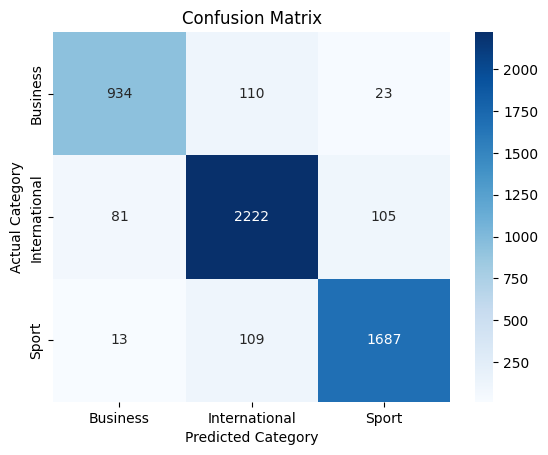

In [10]:
# Evaluate model performance
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
accuracy_percent = accuracy * 100

print("==============================================")
print("✅ FINAL MODEL PERFORMANCE SUMMARY")
print("==============================================")
print(f"Test Accuracy (Decimal): {accuracy:.2f}")
print(f"Test Accuracy (Percentage): {accuracy_percent:.2f}%")
print(f"Test Loss: {loss:.4f}")
print("==============================================\n")

# Predict classes for test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Detailed Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.show()



Visualize the training progress


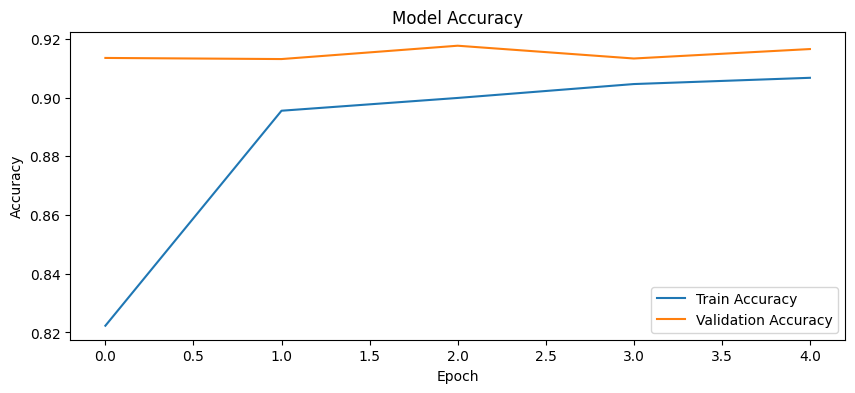

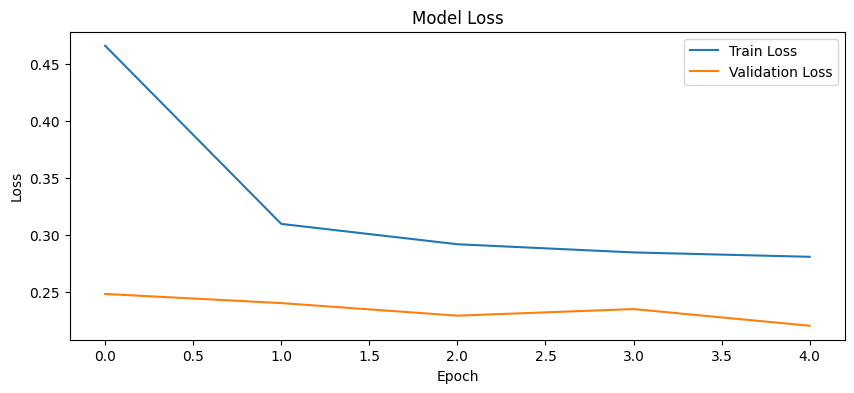

In [11]:
# Visualize accuracy and loss over epochs
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


12. Test the Model with Unseen Sinhala Headlines

Description:
Here we manually test the trained LSTM model with Sinhala news titles that were not part of the dataset.
You can change these headlines and re-run this cell to see how the model predicts new results.

In [12]:
# ---- 🟨 Add your own Sinhala titles here for testing ----
new_titles = [
    "ලංකා තෙල් මිල ඉහළ යයි",                # Likely Business
    "ශ්‍රී ලංකාව ක්‍රිකට් තරගය ජය ගනී",    # Likely Sport
    "ඇමරිකානු ජනපති කතාබස් කිරීමක් කළා"  # Likely International
]

# Clean and preprocess input
new_titles_cleaned = [clean_text(t) for t in new_titles]
new_seq = tokenizer.texts_to_sequences(new_titles_cleaned)
new_pad = pad_sequences(new_seq, maxlen=MAX_LEN, padding='post')

# Predict category
predictions = model.predict(new_pad)
predicted_classes = np.argmax(predictions, axis=1)

# Display results
for i, title in enumerate(new_titles):
    print(f"📰 Title: {title}")
    print(f"➡️ Predicted Category: {le.classes_[predicted_classes[i]]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
📰 Title: ලංකා තෙල් මිල ඉහළ යයි
➡️ Predicted Category: Business

📰 Title: ශ්‍රී ලංකාව ක්‍රිකට් තරගය ජය ගනී
➡️ Predicted Category: Sport

📰 Title: ඇමරිකානු ජනපති කතාබස් කිරීමක් කළා
➡️ Predicted Category: International



13. Conclusion

This Sinhala News Classification model effectively predicts whether a headline belongs to International, Business, or Sport categories.

It uses FastText embeddings for Sinhala word understanding.

LSTM helps it learn the order and context of words.

You can continuously test it with new unseen Sinhala news headlines to verify its performance.